## Load data

In [1]:
from DEAPDataset import DEAPDataset
import numpy as np
from einops import rearrange
import torch
from torch_geometric.nn import GCNConv, GAE, VGAE
from torch_geometric.data import InMemoryDataset, Data, DataLoader

ROOT_DIR = './'
RAW_DIR = 'data/matlabPREPROCESSED'
PROCESSED_DIR = 'data/graphProcessedData'

class args: 
    def __init__(self):
        self.participant_from = 1
        self.participant_to = 1
        self.classification_labels = False
        self.global_connections = False
        

args = args()

dataset = DEAPDataset(root= ROOT_DIR, raw_dir= RAW_DIR, processed_dir=PROCESSED_DIR,args=args,expand_3d=False)

Not using global connections


In [2]:
from util import train_test_split
train_data, test_data = train_test_split(dataset,35)

In [3]:
train_windows = torch.stack([rearrange(data.x,'a (b c) -> b a c',c=128) for data in train_data])
train_windows = rearrange(train_windows,'a b c d -> (a b) c d')
test_windows = torch.stack([rearrange(data.x,'a (b c) -> b a c',c=128) for data in test_data])
test_windows = rearrange(test_windows,'a b c d -> (a b) c d')

In [4]:
edge_index = train_data[0].edge_index
edge_attr = train_data[0].edge_attr
train_windows.shape, test_windows.shape

(torch.Size([2100, 32, 128]), torch.Size([300, 32, 128]))

In [5]:
train_window_data = []
test_window_data = []
for window in train_windows:
    train_window_data.append(Data(x=window,edge_attr=edge_attr,edge_index=edge_index))
for window in test_windows:
    test_window_data.append(Data(x=window,edge_attr=edge_attr,edge_index=edge_index))

In [6]:
train_window_loader = DataLoader(train_window_data, batch_size=64)
test_window_loader = DataLoader(test_window_data, batch_size=64)

## Define model architecture

In [7]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=False)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=False)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=False)

    def forward(self, x, edge_index, edge_attr):
#         print(x.shape, edge_index.shape, edge_attr.shape)
        x = self.conv1(x, edge_index,edge_attr).relu()
        return self.conv_mu(x, edge_index,edge_attr), self.conv_logstd(x, edge_index,edge_attr)
    
out_channels = 16
num_features = dataset.num_features//60
encoder = VGAE(VariationalGCNEncoder(num_features, out_channels))     
pytorch_total_params = sum(p.numel() for p in encoder.parameters())
pytorch_total_params

5184

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
out_channels = 16
num_features = dataset.num_features//60
encoder = VGAE(VariationalGCNEncoder(num_features, out_channels))  
encoder = encoder.to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)

def train():
    encoder.train()
    losses = []
    for window_batch in train_window_loader:
        optimizer.zero_grad()
        window_batch = window_batch.to(device)
#         print(window_batch)
        z = encoder.encode(window_batch.x,window_batch.edge_index,window_batch.edge_attr)
#         print(z.shape)
        loss = encoder.recon_loss(z, window_batch.edge_index)
        # if args.variational:
        loss += (1 / train_data[0].num_nodes) * encoder.kl_loss()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    return np.array(losses).mean()


def test():
    encoder.eval()
    losses = []
    with torch.no_grad():
        for window_batch in test_window_loader:
            window_batch = window_batch.to(device)
            z = encoder.encode(window_batch.x, window_batch.edge_index, window_batch.edge_attr)
            loss = encoder.recon_loss(z, window_batch.edge_index)
            loss += (1 / train_data[0].num_nodes) * encoder.kl_loss()
            losses.append(loss.item())     
    return np.array(losses).mean()

best_val_loss = np.inf
esp = 0
MAX_ESP = 20
# for epoch in range(1, 500):
#     train_loss = train()
#     test_loss = test()
#     if test_loss < best_val_loss:
#         best_val_loss = test_loss
#         esp = 0
#     else:
#         esp += 1
#         if esp >= MAX_ESP:
#             break
#     print(f'Epoch {epoch} ; Train loss: {train_loss} ; Test loss: {test_loss}')

In [10]:
# torch.save(encoder.state_dict(), './encoder')

In [11]:
def test():
    encoder.eval()
    losses = []
    with torch.no_grad():
        for window_batch in test_window_loader:
            window_batch = window_batch.to(device)
            print((window_batch.x.shape, window_batch.edge_index.shape, window_batch.edge_attr.shape))
            z = encoder.encode(window_batch.x, window_batch.edge_index, window_batch.edge_attr)
            loss = encoder.recon_loss(z, window_batch.edge_index)
            loss += (1 / train_data[0].num_nodes) * encoder.kl_loss()
            losses.append(loss.item())     
    return np.array(losses).mean()


out_channels = 16
num_features = dataset.num_features//60
encoder = VGAE(VariationalGCNEncoder(num_features, out_channels))     
encoder.load_state_dict(torch.load('./encoder'))
encoder = encoder.to(device)
encoder.eval()
test()

(torch.Size([2048, 128]), torch.Size([2, 11520]), torch.Size([11520]))
(torch.Size([2048, 128]), torch.Size([2, 11520]), torch.Size([11520]))
(torch.Size([2048, 128]), torch.Size([2, 11520]), torch.Size([11520]))
(torch.Size([2048, 128]), torch.Size([2, 11520]), torch.Size([11520]))
(torch.Size([1408, 128]), torch.Size([2, 7920]), torch.Size([7920]))


1.3198256254196168

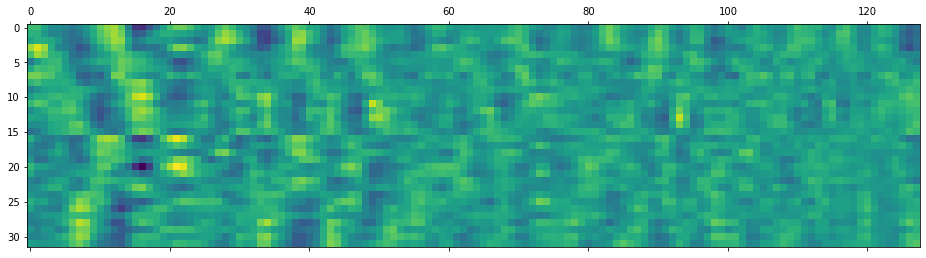

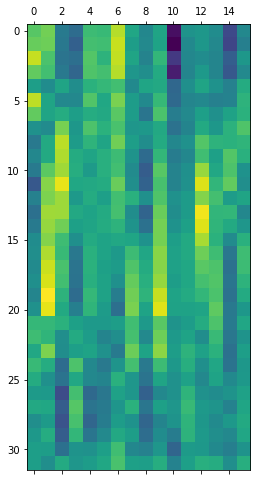

In [12]:
import matplotlib.pyplot as plt
train_windows = train_windows.to(device)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)
window_n = 1
plt.matshow(train_windows[window_n].cpu())
z = encoder.encode(train_windows[window_n],edge_index,edge_attr)
z.shape
plt.matshow(z.cpu().detach().numpy())

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(torch.nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(out_channels, out_channels*2, 2,bidirectional=True)
        self.lin = nn.Linear(60*32*2, 1)

    def forward(self, x):
        x, (c_n,h_n) = self.lstm(x)
        x = x.relu()
        x = F.dropout(x, p=0.15, training=self.training)
        
        x = x.flatten()
        
        x = self.lin(x)
        x = x.relu()
        x = F.dropout(x, p=0.25, training=self.training)
        
        # x = self.conv2(x, edge_index)
        return x



In [14]:
e_edge_index = edge_index.clone().detach()
e_edge_attr = edge_attr.clone().detach()
for i in range(59):
    a = edge_index + e_edge_index.max() + 1
    e_edge_index = torch.cat([e_edge_index,a],dim=1)
    e_edge_attr = torch.cat([e_edge_attr,edge_attr],dim=0)

In [15]:
e_edge_index.shape , e_edge_attr.shape

(torch.Size([2, 10800]), torch.Size([10800]))

In [21]:
import numpy as np
from einops import rearrange

classifier = LSTMClassifier()
pytorch_total_params = sum(p.numel() for p in classifier.parameters())
print(pytorch_total_params)

classifier = classifier.to(device)
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(classifier.parameters(), lr=.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0, centered=False)
optimizer = torch.optim.Adagrad(classifier.parameters(), lr=.01, lr_decay=0.01, weight_decay=.01)

criterion = torch.nn.MSELoss()

e_edge_index = e_edge_index.to(device)
e_edge_attr = e_edge_attr.to(device)

def train():
    classifier.train()
    losses = []
    for data in train_data:
        optimizer.zero_grad()
        data = data.to(device)
        windows = rearrange(data.x,'a (b c) -> (b a) c',c=128)
        windows = windows.to(device)
        z = encoder.encode(windows, e_edge_index,e_edge_attr).detach()

        seq = rearrange(z,'(a b) c -> a b c', b=32)
        seq = seq.mean(dim=1, keepdim=True)
        
        
        out = classifier(seq)
        
        loss = criterion(out,data.y[:,[0]].view(-1))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    return np.array(losses).mean()


def test():
    classifier.eval()
    losses = []
    with torch.no_grad():
        for data in test_data:
            windows = rearrange(data.x,'a (b c) -> b a c',c=128)
            z = encoder.encode(windows, data.edge_index)
            seq = z.mean(axis=1)
            seq = rearrange(seq,'a (b c) -> a c b',c=1)
            out = classifier(seq)
            loss = criterion(out,data.y[:,[0]].view(-1))
            print(out,data.y[:,[0]].view(-1))
            losses.append(loss.item())     
    return np.array(losses).mean()


for epoch in range(1, 1000):
    train_loss = train()
    print(train_loss)
#     test_loss = test()
#     print(f'Epoch {epoch} ; Train loss: {train_loss} ; Test loss: {test_loss} ')

41729
14.939120723908335
15.959222807335546
8.649440267209762
16.366617303660938
15.36925606014473
17.89173627751214
13.593331764851298
13.363212652504444
13.832138300367765
9.137158903053828
10.619210806063244
9.508244504247394
8.3938112616539
9.693812049712454
14.344534191914967
10.0274961744036
14.09476348076548
13.184745819228036
15.541042866025652
15.156505679232733
12.825548353152616
16.67230393545968
15.262235757282802
16.79309821235282
12.607542271912099
10.748407346648829
13.883818819480283
12.344241234234401
15.160172509082726
13.222260922619276
13.7280207829816
14.430651557445525
10.02443518936634
10.376538036763668
16.42485364228487
18.970036928994315
13.559409412315913
18.686772399715014
8.801123820032393
17.737164677892412
11.506505422081267
10.10555678478309
9.554137673122542
12.610084255039691
12.574888984220369
10.616819011313575
12.401744971956525
12.030530322449549
9.416436337573188
17.053730756470134
15.664443244252887
15.27109049707651
13.651983126997948
7.70873832

9.626227686234882
16.25083749805178
10.09711008220911
11.58329028061458
8.575467265078
15.782345310066427
11.266561193125588
18.604771101049014
13.729519193513052
13.207693372453962
17.45400801684175
11.547559817773955
10.254247449125563
11.894391745328903
15.77863083396639
10.368960355860846
13.98744055543627
15.834663355776241
16.841930768106664
11.47095021733216
8.762320869309562
12.691360291412899
17.07140180170536
12.599286044495447
12.969788473418781
12.169378738956793
9.976723601988384
16.5020436670099
12.8415067376835
14.915903921212468
14.510062517864364
7.490169177736555
14.496716676439558
15.357606734974043
12.382463754500662
13.19957066816943
17.95264916483845
12.639024157609258
11.142820460455757
14.98848567690168
14.346231741564614
16.343814601216998
12.120903216089522
9.146590943208762
11.870363470486232
14.156692106383188
18.161092685375895
20.025915653365
18.696501109216893
14.772071123123169
11.085031367199761
10.18411364555359
12.977644484383719
16.90572729642902
15.

12.818754053115844
13.743704229593277
16.53700867167541
10.772676132832254
12.865839381941727
12.921445187500545
9.680510193961007
13.423451280593872
19.70594317615032
12.385784343736512
9.511930045911244
11.573807268483298
17.995420048492296
10.115211289269583
9.362732751028878
15.387810638972692
9.427414630992072
13.009782622115953
21.844514983466695
12.013886724625316
11.50385356758322
11.3837613429342
8.907423251867295
9.922807822908673
15.38682347536087
9.945392076883998
18.014326330593654
11.900720947768008
15.670722509281976
11.057359252657209
12.951217532157898
11.69348906491484
10.364135233419281
13.529215033565249
9.414165464469365
15.806608416352953
17.192338708468846
13.465295117241995
18.240746900013516
13.811664327127593
15.523707664012909
16.063268778153827
15.330216843741281
8.278965249231883
20.85382275070463
9.546510137830461
8.822778787357466
12.530136949675423
13.032750108838082
11.087927344867161
9.44680845269135
16.025250576649395
12.196842724084854
15.18167293540